## Few Business questions that we are trying to answer with this data:
#### 1. Which countries are most people tweeting from? <br> 2. What source have people used while tweeting <br> 3. Most common hash tag used <br> 4. Daily tweets' trend <br> 5. Most followed people and their description? <br> 6. What is the sentiment in peoples' tweet? <br> 7. Does most favoritized tweet has any sentiment pattern/ trend? <br> 8. Does the sentiment has any correlation with country?

## Import Libraries and Data Load

In [110]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import string
import re
from datetime import datetime
import matplotlib.pyplot as plt
import branca.colormap as cm
from mpl_toolkits.basemap import Basemap
import requests
import folium
from nltk import tokenize
from nltk.tokenize import TweetTokenizer #word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from tqdm import tqdm, notebook
#from tqdm.notebook import tqdm

#! pip install basemap
#! conda install -c conda-forge basemap-data-hires --yes
#! pip install branca==0.4.1 #0.3.1
#! pip install wordcloud

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-tweets/covid19_tweets.csv


In [3]:
df = pd.read_csv(os.path.join(dirname, filename))
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs #Resist,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,"🖊️Official Twitter handle of Department of Information and Public Relations, Govt of Jammu & Kashmir",2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI… https://t.co/MN0EEcsJHh,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


## Exploration Data Analysis (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


In [5]:
# data has duplicated tweets but their is_retweets is false so keeping these in for geo analyses
# df[df['text'].duplicated()==True]

In [6]:
# There are no retweets in the data
df['is_retweet'].value_counts()

False    179108
Name: is_retweet, dtype: int64

In [7]:
# ~15% tweets have been tweeted by verified users
df['user_verified'].value_counts(normalize=True)

False    0.871055
True     0.128945
Name: user_verified, dtype: float64

In [8]:
df.describe()

,user_followers,user_friends,user_favourites
count,1.791080e+05,179108.000000,1.791080e+05
mean,1.090555e+05,2121.701566,1.444411e+04
std,8.414670e+05,9162.553072,4.452270e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.720000e+02,148.000000,2.060000e+02
50%,9.920000e+02,542.000000,1.791000e+03
75%,5.284000e+03,1725.250000,9.388000e+03
max,4.944256e+07,497363.000000,2.047197e+06


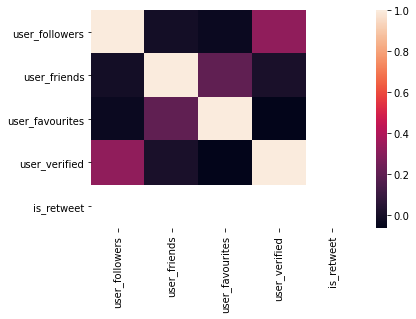

In [9]:
sns.heatmap(df.corr())

## Detailed Analysis

In [10]:
# Make a copy of dataframe before making any changes
tweets = df.copy()

In [11]:
# Convert date columns to datetime data type from object
tweets['date'] = pd.to_datetime(tweets['date'])
tweets['user_created'] = pd.to_datetime(tweets['user_created'])
tweets['date_ext'] = tweets['date'].dt.date


In [12]:
# Take care of nulls in location and description
tweets.user_location.fillna('Unknown', inplace=True)
tweets.user_description.fillna('Unknown', inplace=True)
tweets.source.fillna('Unknown', inplace=True)
tweets.hashtags.fillna('None', inplace=True)

In [13]:
# Verify
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_name         179108 non-null  object        
 1   user_location     179108 non-null  object        
 2   user_description  179108 non-null  object        
 3   user_created      179108 non-null  datetime64[ns]
 4   user_followers    179108 non-null  int64         
 5   user_friends      179108 non-null  int64         
 6   user_favourites   179108 non-null  int64         
 7   user_verified     179108 non-null  bool          
 8   date              179108 non-null  datetime64[ns]
 9   text              179108 non-null  object        
 10  hashtags          179108 non-null  object        
 11  source            179108 non-null  object        
 12  is_retweet        179108 non-null  bool          
 13  date_ext          179108 non-null  object        
dtypes: b

In [14]:
# Attempt tp clean the location column. There are many other business rules that can be applied to 
# improve the accuracy of different cases. We can also use regular expressions

# If both country and city is mentioned

tweets["country"] = tweets.user_location.apply(lambda x: x.split(",")[-1].strip() \
                                            if ("," in x) else x)
tweets["city"] = tweets.user_location.apply(lambda x: x.split(",")[0].strip() \
                                            if ("," in x) else x)

# Replacing 2 digit US states with USA except UK
tweets["country"] = tweets.country.apply(lambda x: 'USA' if len(x.lower().strip())<3 and x!='uk' else x)

# Standarizing case senstive cases
tweets["country"] = tweets.country.apply(lambda x: 'USA' if x.lower().strip() in \
                                      ("united states, usa, us") else x)
tweets["country"] = tweets.country.apply(lambda x: 'India' if x.lower().strip() in \
                                      ("india") else x)

In [15]:
tweets["city"] = tweets.city.apply(lambda x: 'Unknown' if x.lower() in \
                                   ['india', 'united states', 'united kingdom', 'uk', 'usa', 'us'] \
                                   else x)

In [16]:
#tweets.country.value_counts().to_frame().style.bar()
#tweets.city.value_counts().to_frame().style.bar()

#### We see that US and India are the top countries from where most of the people have tweeted with USA being significantly higher. The top 5 cities with highest tweets are London, New Delhi, New York, Mumbai, Washington.

## Plot heatmap to see the geographical distribution based on number of tweets

In [17]:
# Taking top 100 countries and cities excluding the unknown at index 0
top100_count = tweets.country.value_counts(sort=True, ascending=False)[1:101]
top100_count = pd.DataFrame(top100_count)

top100_city= tweets.city.value_counts(sort=True, ascending=False)[1:101]
top100_city = pd.DataFrame(top100_city)

In [18]:
def get_coordinates(input_type, name, output_as='center'):
     # create url
    if input_type == "country":
        url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search?country=',name,'&format=json&polygon=0')
    elif input_type == "city":
        url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search?city=',name,'&format=json&polygon=0')
    response = requests.get(url)
    try:
        response = response.json()[0]
        # parse response to list
        if output_as == 'center':
            lst = [response.get(key) for key in ['lat','lon']]
            output = [float(i) for i in lst]
        if output_as == 'boundingbox':
            lst = response[output_as]
            output = [float(i) for i in lst]
        return output
    
    except (IndexError, ValueError):
        # this will log the whole traceback
        return [0,0]

In [19]:
# Get the latitudes and longitudes for the top 100 countries and cities
lat_long_count = [get_coordinates("country",coun) for coun in top100_count.index]
lat_long_city = [get_coordinates("city",city) for city in top100_city.index]

In [20]:
# Call the get_coodinates() and drop the duplicates from dataframe
def top100_df(input_type,df,lat_long):
    # merge lat and long with original dataframe
    for i, pair in zip(df.index, lat_long):
        df.loc[i,'lat'] = pair[0]
        df.loc[i,'long'] = pair[1] 
    # reset the index as country names
    df.reset_index(level=0, inplace=True)
    if input_type=="country":
        df.rename(columns={"country":"# of tweets","index":"country"}, inplace=True)
    elif input_type=="city":
        df.rename(columns={"city":"# of tweets","index":"city"}, inplace=True)
    # drop the countries/ cities with unidetified and duplicated latitudes and longitudes
    df.drop_duplicates(subset=['lat','long'],inplace=True)
    return df

In [21]:
# Call the top100_df() to finalize the country and city dataframes 
top100_count = top100_df("country",top100_count,lat_long_count)
top100_city = top100_df("city",top100_city,lat_long_city)

In [22]:
# Create a heatmap using folium
from folium import plugins
from folium.plugins import HeatMap
import branca.colormap

def color(magnitude):
    if magnitude>=2000:
        col='red'
    elif (magnitude>=500 and magnitude<2000):
        col='beige'
    elif magnitude<500:
        col='green'
    return col

def generateBaseMap(input_type,df,default_location=[40.693943, -73.985880], default_zoom_start=2):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    marker_cluster = plugins.MarkerCluster().add_to(base_map)
    
    HeatMap(data=df[['lat','long']].values.tolist(),radius=20,max_zoom=13).add_to(base_map)
    for lat,lan,tweet,name in zip(df['lat'],df['long'],df['# of tweets'],df.iloc[:,0]): 
        # Marker() takes location coordinates as a list as an argument 
        folium.Marker(location=[lat,lan],popup = [name,tweet], 
                      icon= folium.Icon(color=color(tweet), 
                      icon_color='white', icon='twitter', prefix='fa')).add_to(marker_cluster)
    #specify the min and max values of your data
    min, max = df['# of tweets'].min(), df['# of tweets'].max()
    colormap = cm.LinearColormap(colors=['green','beige','red'], vmin=min,vmax=max)
    if input_type=='country':
        colormap.caption = 'Country '+'distribution of COVID-19 tweets'
    elif input_type=='city':
         colormap.caption = 'City '+'distribution of COVID-19 tweets'
    colormap.add_to(base_map)
    return base_map

In [23]:
generateBaseMap('country',top100_count)

In [24]:
generateBaseMap('city',top100_city)

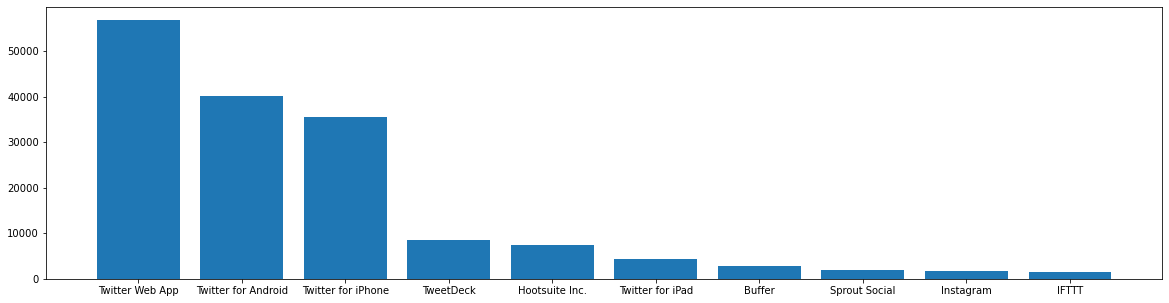

In [25]:
# Compare the tweet source
top10_source = tweets.source.value_counts().nlargest(10)
# initiate the figure with it's size
fig = plt.figure(figsize = (20,5))
plt.bar(top10_source.index, top10_source.values);

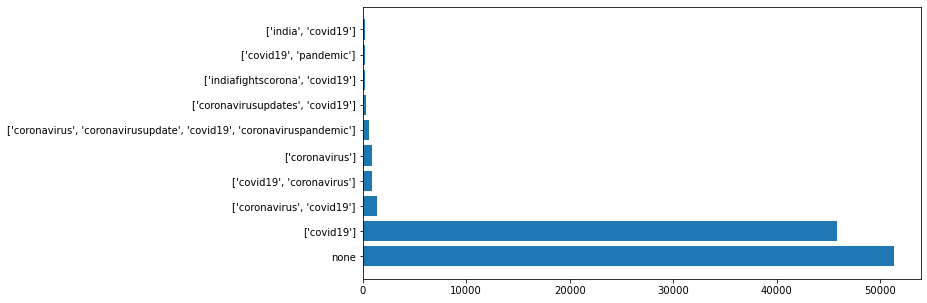

In [26]:
# Most trended hashtags
top10_hashtags = tweets.hashtags.str.lower().value_counts().nlargest(10)
# initiate the figure with it's size
fig = plt.figure(figsize = (10,5))
plt.barh(top10_hashtags.index, top10_hashtags.values);
#plt.xticks(rotation=90);

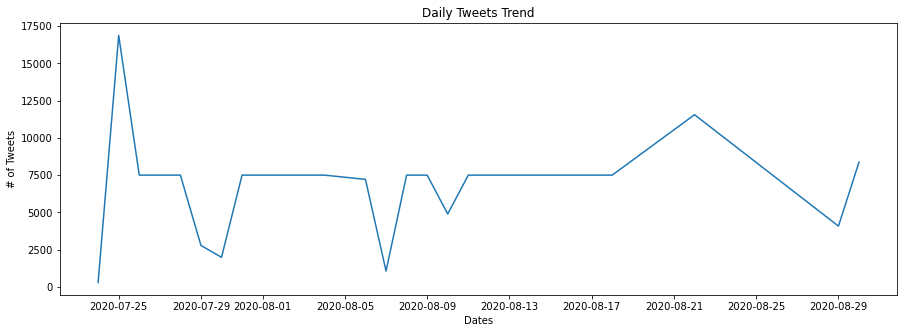

In [27]:
# Daily tweet trend
daily_tweets = tweets.groupby(['date_ext'])['text'].count()

fig = plt.figure(figsize = (15,5))
plt.plot(daily_tweets.index,daily_tweets.values)
plt.title('Daily Tweets Trend')
plt.xlabel('Dates')
plt.ylabel('# of Tweets')
plt.show()

In [28]:
#unique_users = tweets.user_name.duplicated()

In [30]:
# Top 10 followed twitter accounts
top10users = tweets.groupby(by=["user_name"])['user_followers'].max().sort_values(ascending=False)[:10]
top10users.to_frame().style.bar()

,user_followers
user_name,
CNN,49442559
National Geographic,24359165
CGTN,13892841
NDTV,13568396
The Times Of India,13057020
United Nations,12806543
China Xinhua News,12681192
CNN International,11081219
WIRED,10380131


#### CNN, CGTN, and NDTV are the top 3 twitter accounts to be most followed with CNN leading the list having over 49m followers.

## Check sentiment of tweets
### Preprocessing text

In [332]:
# Normalize the text, convert everything other than a-z, A-Z, 0-9 to space
tweets['clean_tweet'] = tweets['text'].apply(lambda x: re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x))

### Create WordCloud

In [334]:
def createWordCloud(text):
    wordcloud = WordCloud(width = 1000, height = 600, 
                      #colormap = 'Paired',
                      background_color ='white',
                      collocations = False,
                      stopwords=stop_words,
                     ).generate(text)

    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.title("Common Entities in the tweets \n", fontsize=20, color='Black')
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

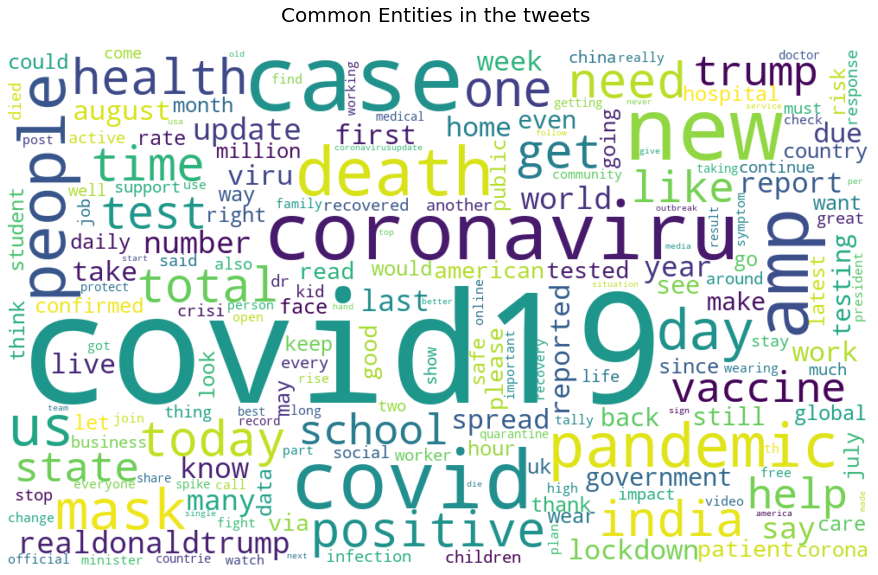

In [335]:
# Create a wordcloud for most popular words in tweets

text = '' 
stop_words = set(stopwords.words("english"))
for row in tweets['clean_tweet']:
    # typecaste each row to string and split it to get tokens
    tokens = str(row).split()
    #row = row.replace("'", "")
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    text += " ".join(tokens)+" "

createWordCloud(text)

#### As expected, the most common words that pop up are COVID19, coronavirus, pandemic, vaccine etc.

### Calculate Sentiments

In [336]:
# We are using Compound score to detect the tweet sentiment which is a metric that calculates the sum of
# all the lexicon ratings which have been normalized between 
# -1(most extreme negative) and +1 (most extreme positive)
# positive: (compound score >= 0.05), negative : (compound score <= -0.05), neutral otherwise
def getSentiment(df):
    sid = SentimentIntensityAnalyzer()
    for index, row in tqdm(df.iterrows()): #tqdm 
        ss = sid.polarity_scores(row['clean_tweet'])
        if ss['compound'] >= 0.05 : 
            df.at[index,'sentiment'] = "Positive"

        elif ss['compound'] <= - 0.05 : 
            df.at[index,'sentiment'] = "Negative"

        else : 
            df.at[index,'sentiment'] = "Neutral"
    return df

In [112]:
getSentiment(tweets)

10it [00:00, 1128.38it/s]


,nor_text,sentiment
0,If I smelled the scent of hand sanitizers today on someone in the past I would think they were so intoxicated that,Positive
1,Hey Yankees YankeesPR and MLB wouldn t it have made more sense to have the players pay their respects to the A,Positive
2,diane3443 wdunlap realDonaldTrump Trump never once claimed COVID19 was a hoax We all claim that this effort to,Negative
3,brookbanktv The one gift COVID19 has give me is an appreciation for the simple things that were always around me,Positive
4,25 July Media Bulletin on Novel CoronaVirusUpdates COVID19 kansalrohit69 DrSyedSehrish airnewsalerts ANI,Positive
5,coronavirus covid19 deaths continue to rise It s almost as bad as it ever was Politicians and businesses want,Negative
6,How COVID19 Will Change Work in General and recruiting specifically via ProactiveTalent Recruiting,Neutral
7,You now have to wear face coverings when out shopping this includes a visit to your local Community Pharmacy,Neutral
8,Praying for good health and recovery of ChouhanShivraj covid19 covidPositive,Positive
9,POPE AS GOD Prophet Sadhu Sundar Selvaraj Watch here at HurricaneHanna COVID19,Positive


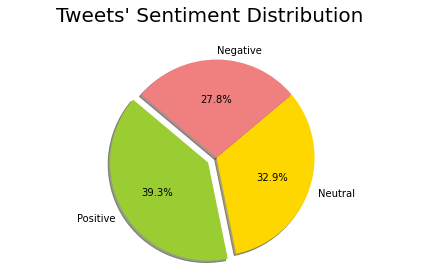

In [39]:
# Show distribution of tweet sentiments (pie?) and wordcloud of each
#sentiment_dist = tweets.groupby(by=['sentiment'])['sentiment'].count()
# Plot sentiment distribution
sentiment_dist = tweets.sentiment.value_counts()

plt.pie(sentiment_dist, labels=sentiment_dist.index, explode= (0.1,0,0),
        colors=['yellowgreen', 'gold', 'lightcoral'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Tweets\' Sentiment Distribution \n", fontsize=20, color='Black')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [300]:
# Word clouds for positive and negative tweets
positive_tweets = tweets.query("sentiment=='Positive'")
negative_tweets = tweets.query("sentiment=='Negative'")
neutral_tweets = tweets.query("sentiment=='Neutral'")

In [337]:
# Sentiment of top 10 favoritized tweets
top10tweets = tweets.nlargest(10, ['user_favourites'])[['user_name','clean_tweet','user_verified']]
top10tweetsentiments = getSentiment(top10tweets)
top10tweetsentiments.groupby(by=['user_name','sentiment'])['clean_tweet'].count().to_frame().style.bar()

10it [00:00, 1049.70it/s]


#### Top favoritized tweets are showcasing concerns about COVID-19 and about the rising COVID-19 cases. Majority of these tweets have been by 'Paolo Ignazio Marong'. Surprisingly, none of these 3 users viz. Patty, Paolo, and Chelsea are verified users but still got their tweet favoritized the most.

### Check Most Frequent Entities

100%|██████████| 179108/179108 [14:36<00:00, 204.43it/s]


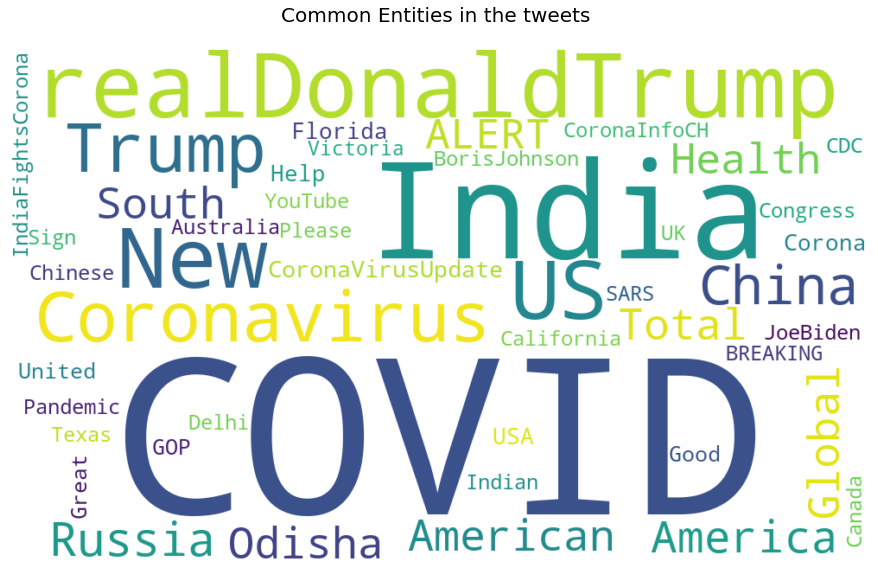

In [358]:
# Create dictionary of entities and their frequency in the tweets then create a wordcloud

entities={}
for sent in tqdm(tweets.clean_tweet):
    for chunk in ne_chunk(pos_tag(tt.tokenize(sent)), binary=True):
        if hasattr(chunk, 'label'):
            if chunk[0][0] in entities.keys():
                entities[chunk[0][0]] = entities[chunk[0][0]]+1
            else:
                entities[chunk[0][0]]=1
                
#sorted by key, return a list of tuples. To convert to a dictionary use dict()    
top50_entities = sorted(entities.items(), key=lambda x: x[1], reverse=True)[:50]
entities_text = " ".join([(k + " ")*v for k,v in dict(top50_entities).items()])
createWordCloud(entities_text)

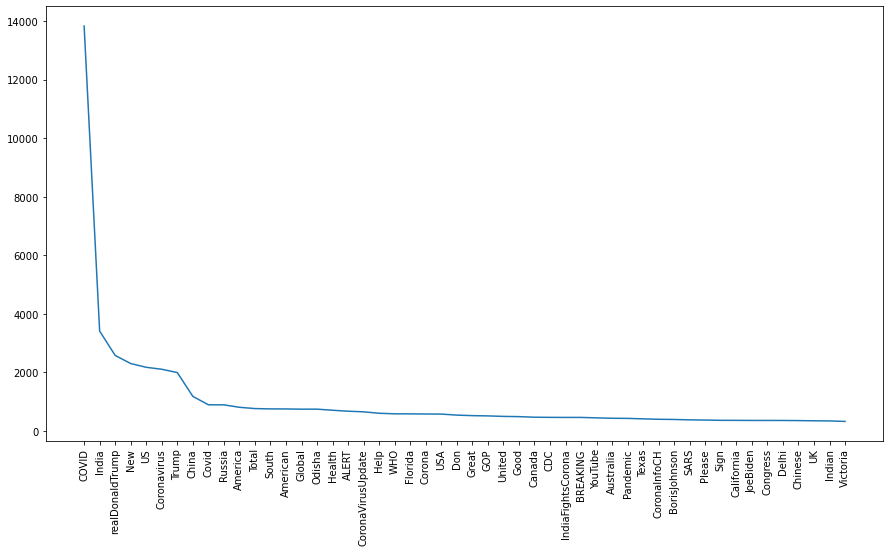

In [360]:
# Plot the most frequent entities to show the frequency trend line
x, y = zip(*top50_entities) # unpack a list of pairs into two tuples

plt.figure(figsize=[15,8])
plt.plot(x, y)
plt.xticks(rotation=90)
plt.show()

In [43]:
# check size of notebook
!ls -lh

"""! jupyter trust __notebook_source__.ipynb
my_submission = pd.DataFrame({'Id': test.Id, 'col2': col2})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)"""

total 4.0K
---------- 1 root root 263 Aug 30 18:24 __notebook_source__.ipynb


"! jupyter trust __notebook_source__.ipynb\nmy_submission = pd.DataFrame({'Id': test.Id, 'col2': col2})\n# you could use any filename. We choose submission here\nmy_submission.to_csv('submission.csv', index=False)"

## References
- https://stackoverflow.com/questions/44173624/how-to-apply-nltk-word-tokenize-library-on-a-pandas-dataf**rame-for-twitter-data
- https://basemaptutorial.readthedocs.io/en/latest/plotting_data.html#text
- https://zapcircle.net/geomapping-with-python/
- https://matplotlib.org/basemap/users/geography.html
- https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
- https://colab.research.google.com/drive/1HJB7UGj7YuUEJi-cKZRAr3O4Dlym2KrP#scrollTo=0H-uRYF1iIjS
- https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
- https://www.geeksforgeeks.org/generating-word-cloud-python/
- https://www.nltk.org/howto/sentiment.html
- https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
    